## Recovery System Activation Simulation

This notebook presents a simulation of the code responsible for activating the parachute deployment of Andrômeda I recovery system, which is designed for the Latin American Space Challenge 2020 (LASC). The original code was developed on Arduino IDE and the simulation comprises the test of the activations steps, highlighting the system redundancy. The primary activation sensor is th PION altimeter, which measures the rocket altitude. The secondary sensors, which provide the system redundancy, are the MPU X and the BMP Y. They measure, respectively, the tocket altitude and its rotation. 

### Conditions for parachute deployment

 - <b> Altitude:</b> Rocket already achieved its apogee (m);

In [445]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
from random import randint

### Rocket Trajectory


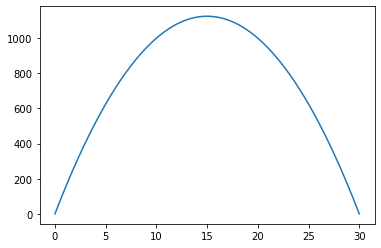

In [446]:
x = np.linspace(0,30,3001) #Alcance: 30 s;
alfa = 5.0 #Apogee of 1125 m; alfa = Apogee/((time/2)^2) 
#y = -alfa*x*(x-30)
y = -alfa*(x**2)+30*alfa*x
plt.plot(x,y)
plt.show()

### White Gaussian Noise function

A white gaussian noise is used for simulating instabilities in the recovery system transmission. The function below produces this form of noise.

In [447]:
def noise(t, sigma):
    # White Gaussian Noise Function
    # t: number of points; sigma: standard deviation
    average_value = 0.0
    std_deviation = sigma
    number_points = t
    noise = np.random.normal(loc=average_value, scale=std_deviation, size=number_points)
    return noise

### Trajectory

A função abaixo mostra a lógica utilizada para a ejeção. Esta recebe a trajetória e a diferença necessária para incrementar o contador da redundância e retorna os pontos em que os dados começam a ser gravados na ROM e que ocorre a ejeção. O contador da redundância representa a distância que o foguete deverá percorrer entre uma leitura e outra para que o contador seja incrementado.

In [561]:
def points(x, y):
    # Trajectory points
    count=0
    initial_altitude = 0
    first_altitude = 0
    second_altitude = 0
    apogee = 1125 # m
    cont_redund = 0
    br1=[0]
    br2=[0]
    p_c1 = [0,0] # First channel identified apogee or not
    p_c2 = [0,0] # Second channel identified apogee or not
    
    for i in range(1,len(x)):
        count+=1
        current_altitude = y[i]
        mean_altitude_1 = (first_altitude + second_altitude)/2.0
        delta_altitude_1 = first_altitude - second_altitude
        mean_altitude_2 = (second_altitude + current_altitude)/2.0
        delta_altitude_2 = second_altitude - current_altitude
        channel_1_active = randint(0,1) # simulate if the first channel is transmitting the data
        channel_2_active = randint(0,1) # simulate if the second channel is transmitting the data
        
        if count >= 2:
            if (mean_altitude_2 < mean_altitude_1 and delta_altitude_2 - delta_altitude_1 < -1 and br1[0] == 0 and br2[0] == 0) : 
                # Simulated automatic apogee detection
                br1 = random.choices([0,1], [0.3, 0.7]) # Simulated probabilty of failure (30%) - selected to show the redundancy
                br2 = random.choices([0,1], [0.3, 0.7]) # Simulated probabilty of failure (30%) - selected to show the redundancy               
                if br1[0] == 1: 
                    # firts channel sucessfully transmits that apogee was detected
                    p_c1 = [x[i], float("%.2f" % round(y[i],2))]
                br2 = random.choices([0,1], [0.5, 0.5]) # Simulated probabilty of failure (30%) - selected to show the redundancy
                if br2[0] == 1: 
                    # second channel sucessfully transmits that apogee was detected
                    p_c2 = [x[i], float("%.2f" % round(y[i],2))]
            elif br1[0] == 0:
                cont_redund += 1
            elif br1[0] == 1:
                cont_redund = 0
        first_altitude = second_altitude
        second_altitude = current_altitude
    return p_c1, p_c2

In [562]:
altitude_noise = noise(len(x),0.2)

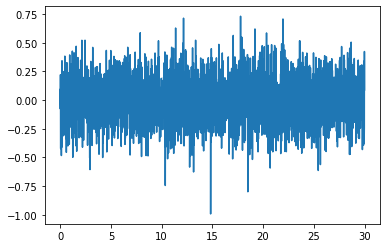

In [563]:
plt.plot(x,altitude_noise)
plt.show()

### Trajectory (recursive approach)

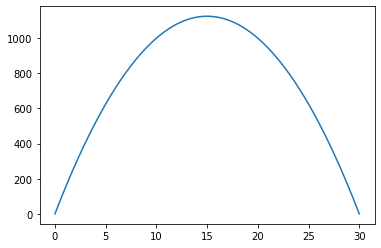

In [564]:
y[0] = 0
alfa = 5.0
for i in range(1,len(x)):
    y[i] = y[i-1] + alfa*(30*0.01 - 2*0.01*x[i-1] - 0.01**2)

plt.plot(x,y)
plt.show()

### Trajectory with simulated aerodynamical instabilites

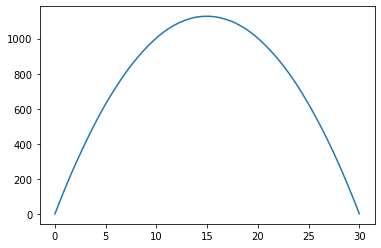

In [565]:
y[0] = 0
alfa = 5.0
for i in range(1,len(x)):
    if i < 50:
        y[i] = y[i-1] + alfa*(30*0.01 - 2*0.01*x[i-1] - 0.01**2)
    elif y[i-1]>0:
        y[i] = y[i-1] + alfa*(30*0.01 - 2*0.01*x[i-1] - 0.01**2) + 0.1*(randint(0,1)*randint(-1,1))
    else:
        y[i] = 0
    

plt.plot(x,y)
plt.show()

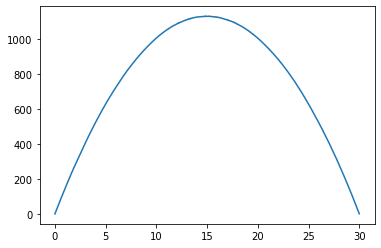

In [566]:
plt.plot(x,y+altitude_noise)
plt.show()

In [579]:
p_c1, p_c2 = points(x, y+altitude_noise)

In [580]:
p_c1

[0, 0]

In [581]:
p_c2

[13.450000000000001, 1111.25]

### Trajectory plot with ejection points

In the graph below, the points where the algorithm detects the apogee are detected. If a green point is displayed, it means that the channel 1 successfully transmitted the information about the apogee detection. However, if a red point is shown, it means that the channel 1 failed to transmit the information about the apogee detection and channel 2 guaranteed the ejection redundancy.

<function matplotlib.pyplot.show(*args, **kw)>

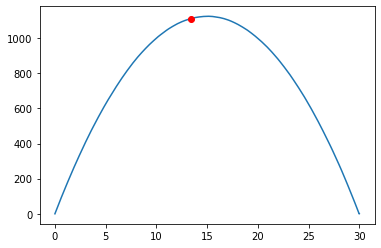

In [582]:
plt.plot(x,y)
if p_c1[0] !=0:
    plt.plot(p_c1[0],p_c1[1], marker='o', markersize=6, color="green", label = "oi")
else:
    plt.plot(p_c2[0],p_c2[1], marker='o', markersize=6, color="red", label = "oi")
plt.show

### Evaluating the apogee detection for different trajectories

[13.56, 1113.4]
[14.700000000000001, 1124.28]
[15.16, 1124.61]
[13.39, 1114.27]
[0, 0]
[10.98, 1042.82]
[13.16, 1109.94]
[14.75, 1123.63]
[15.1, 1128.53]
[13.38, 1111.16]


<function matplotlib.pyplot.show(*args, **kw)>

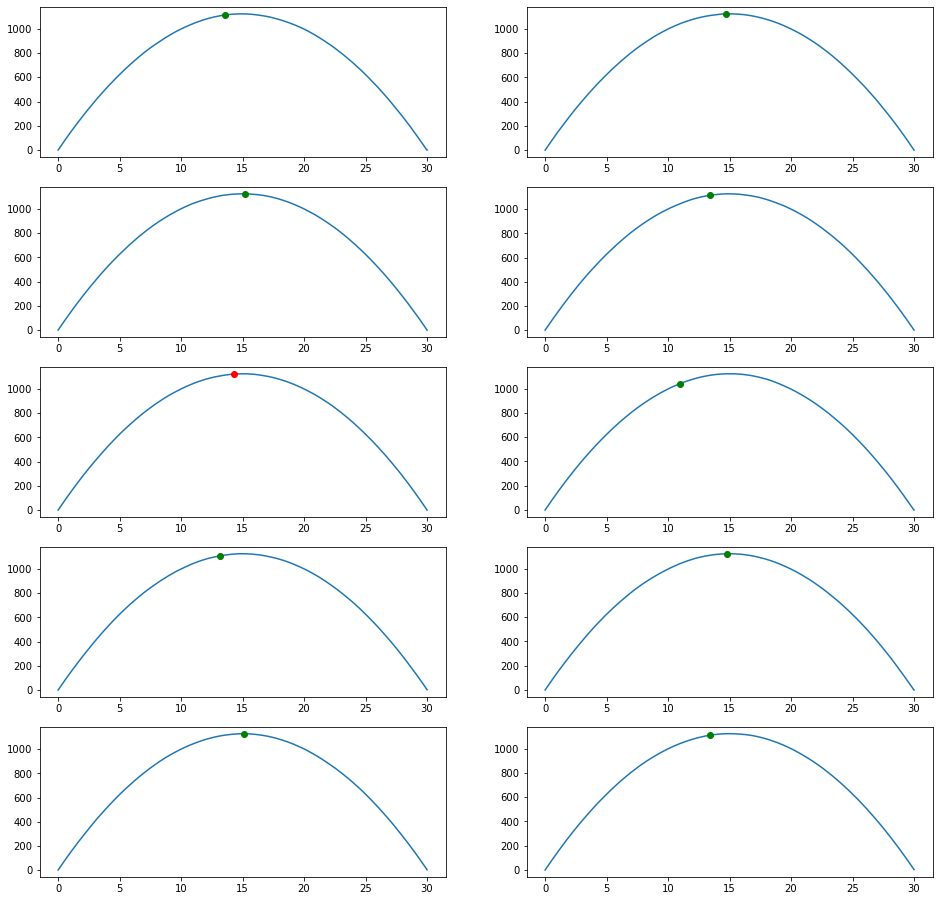

In [583]:
fig, axs = plt.subplots(5,2, gridspec_kw = {'width_ratios':[1,1]}, figsize=(16,16))
for j in range(0,5):
    for k in range (0,2):
        x = np.linspace(0,30,3001) 
        y[0] = 0
        alfa = 5.0
        for i in range(1,len(x)):
            if i < 50:
                y[i] = y[i-1] + alfa*(30*0.01 - 2*0.01*x[i-1] - 0.01**2)
            elif y[i-1]>0:
                y[i] = y[i-1] + alfa*(30*0.01 - 2*0.01*x[i-1] - 0.01**2) + 0.1*(randint(0,1)*randint(-1,1))
            else:
                y[i] = 0
        altitude_noise = noise(len(x),0.2)
        p_c1, p_c2 = points(x, y+altitude_noise)
        print(p_c1)
        axs[j,k].plot(x,y)
        if p_c1[0] !=0:
            axs[j,k].plot(p_c1[0],p_c1[1], marker='o', markersize=6, color="green", label = "oi")
        else:
            axs[j,k].plot(p_c2[0],p_c2[1], marker='o', markersize=6, color="red", label = "oi")
plt.show